In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf


# The PetFinder.my mini dataset
There are several thousand rows in the PetFinder.my mini's CSV dataset file, where each row describes a pet (a dog or a cat) and each column describes an attribute, such as age, breed, color, and so on.

In the dataset's summary below, notice there are mostly numerical and categorical columns. In this tutorial, you will only be dealing with those two feature types, dropping Description (a free text feature) and AdoptionSpeed (a classification feature) during data preprocessing.



In [30]:
# Get the data
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url, extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


### Making the task a binary classification task

The original problem was to predict the adoption speed (categorical number). We'll turn it into a binary classification
task to see wether the animal was adopted or not.

In [31]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

### Split the DataFrame into training, validation, and test sets

In [32]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


### Create an input pipeline using tf.data

In [21]:
# Converts the dataframe into a tf dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')

  df = {key: value[:] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))

  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)

  return ds

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

# This outputs a batch according to the batch_size
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor([12  3 16  2  4], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)


### Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.

* For numerical features of the PetFinder.my mini dataset, you will use a tf.keras.layers.Normalization layer to standardize the distribution of the data.
* For categorical features, such as pet Types (Dog and Cat strings), you will transform them to multi-hot encoded tensors with tf.keras.layers.CategoryEncoding.

#### Numerical Columns

In [25]:
#Define a new utility function that returns a layer which applies feature-wise normalization to numerical 
# features using that Keras preprocessing layer
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

# test the new function by calling it on the total uploaded pet photo features to normalize 'PhotoAmt'
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.8434547 , -0.19398312,  0.45548844, -0.8434547 ,  0.13075265],
      dtype=float32)>

#### Categorical columns

Pet Types in the dataset are represented as strings—Dogs and Cats—which need to be multi-hot encoded before being fed into the model. 


In [28]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type', dataset=train_ds, dtype='string')
print (test_type_layer(test_type_col))

test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age', dataset=train_ds, dtype='int64', max_tokens=5)
print (test_age_layer(test_age_col))

tf.Tensor([0. 1. 1.], shape=(3,), dtype=float32)
tf.Tensor([1. 1. 1. 0. 1.], shape=(5,), dtype=float32)


### Preprocess selected features to train the model on

* Apply the preprocessing utility functions defined earlier on 13 numerical and categorical features from the PetFinder.my mini dataset.
* Add all the feature inputs to a list.

In [33]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [34]:
# Normalize the numerical features (the number of pet photos and the adoption fee), 
# and add them to one list of inputs called encoded_features:

all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


# Categorical features.

# Turn the integer categorical values from the dataset (the pet age) into integer indices, 
# perform multi-hot encoding, and add the resulting feature inputs to encoded_features:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer(name='Age', dataset=train_ds, dtype='int64', max_tokens=5)

encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

# Repeat the same step for the string categorical values:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='string', max_tokens=5)

  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


### Create, compile, and train the model

In [36]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

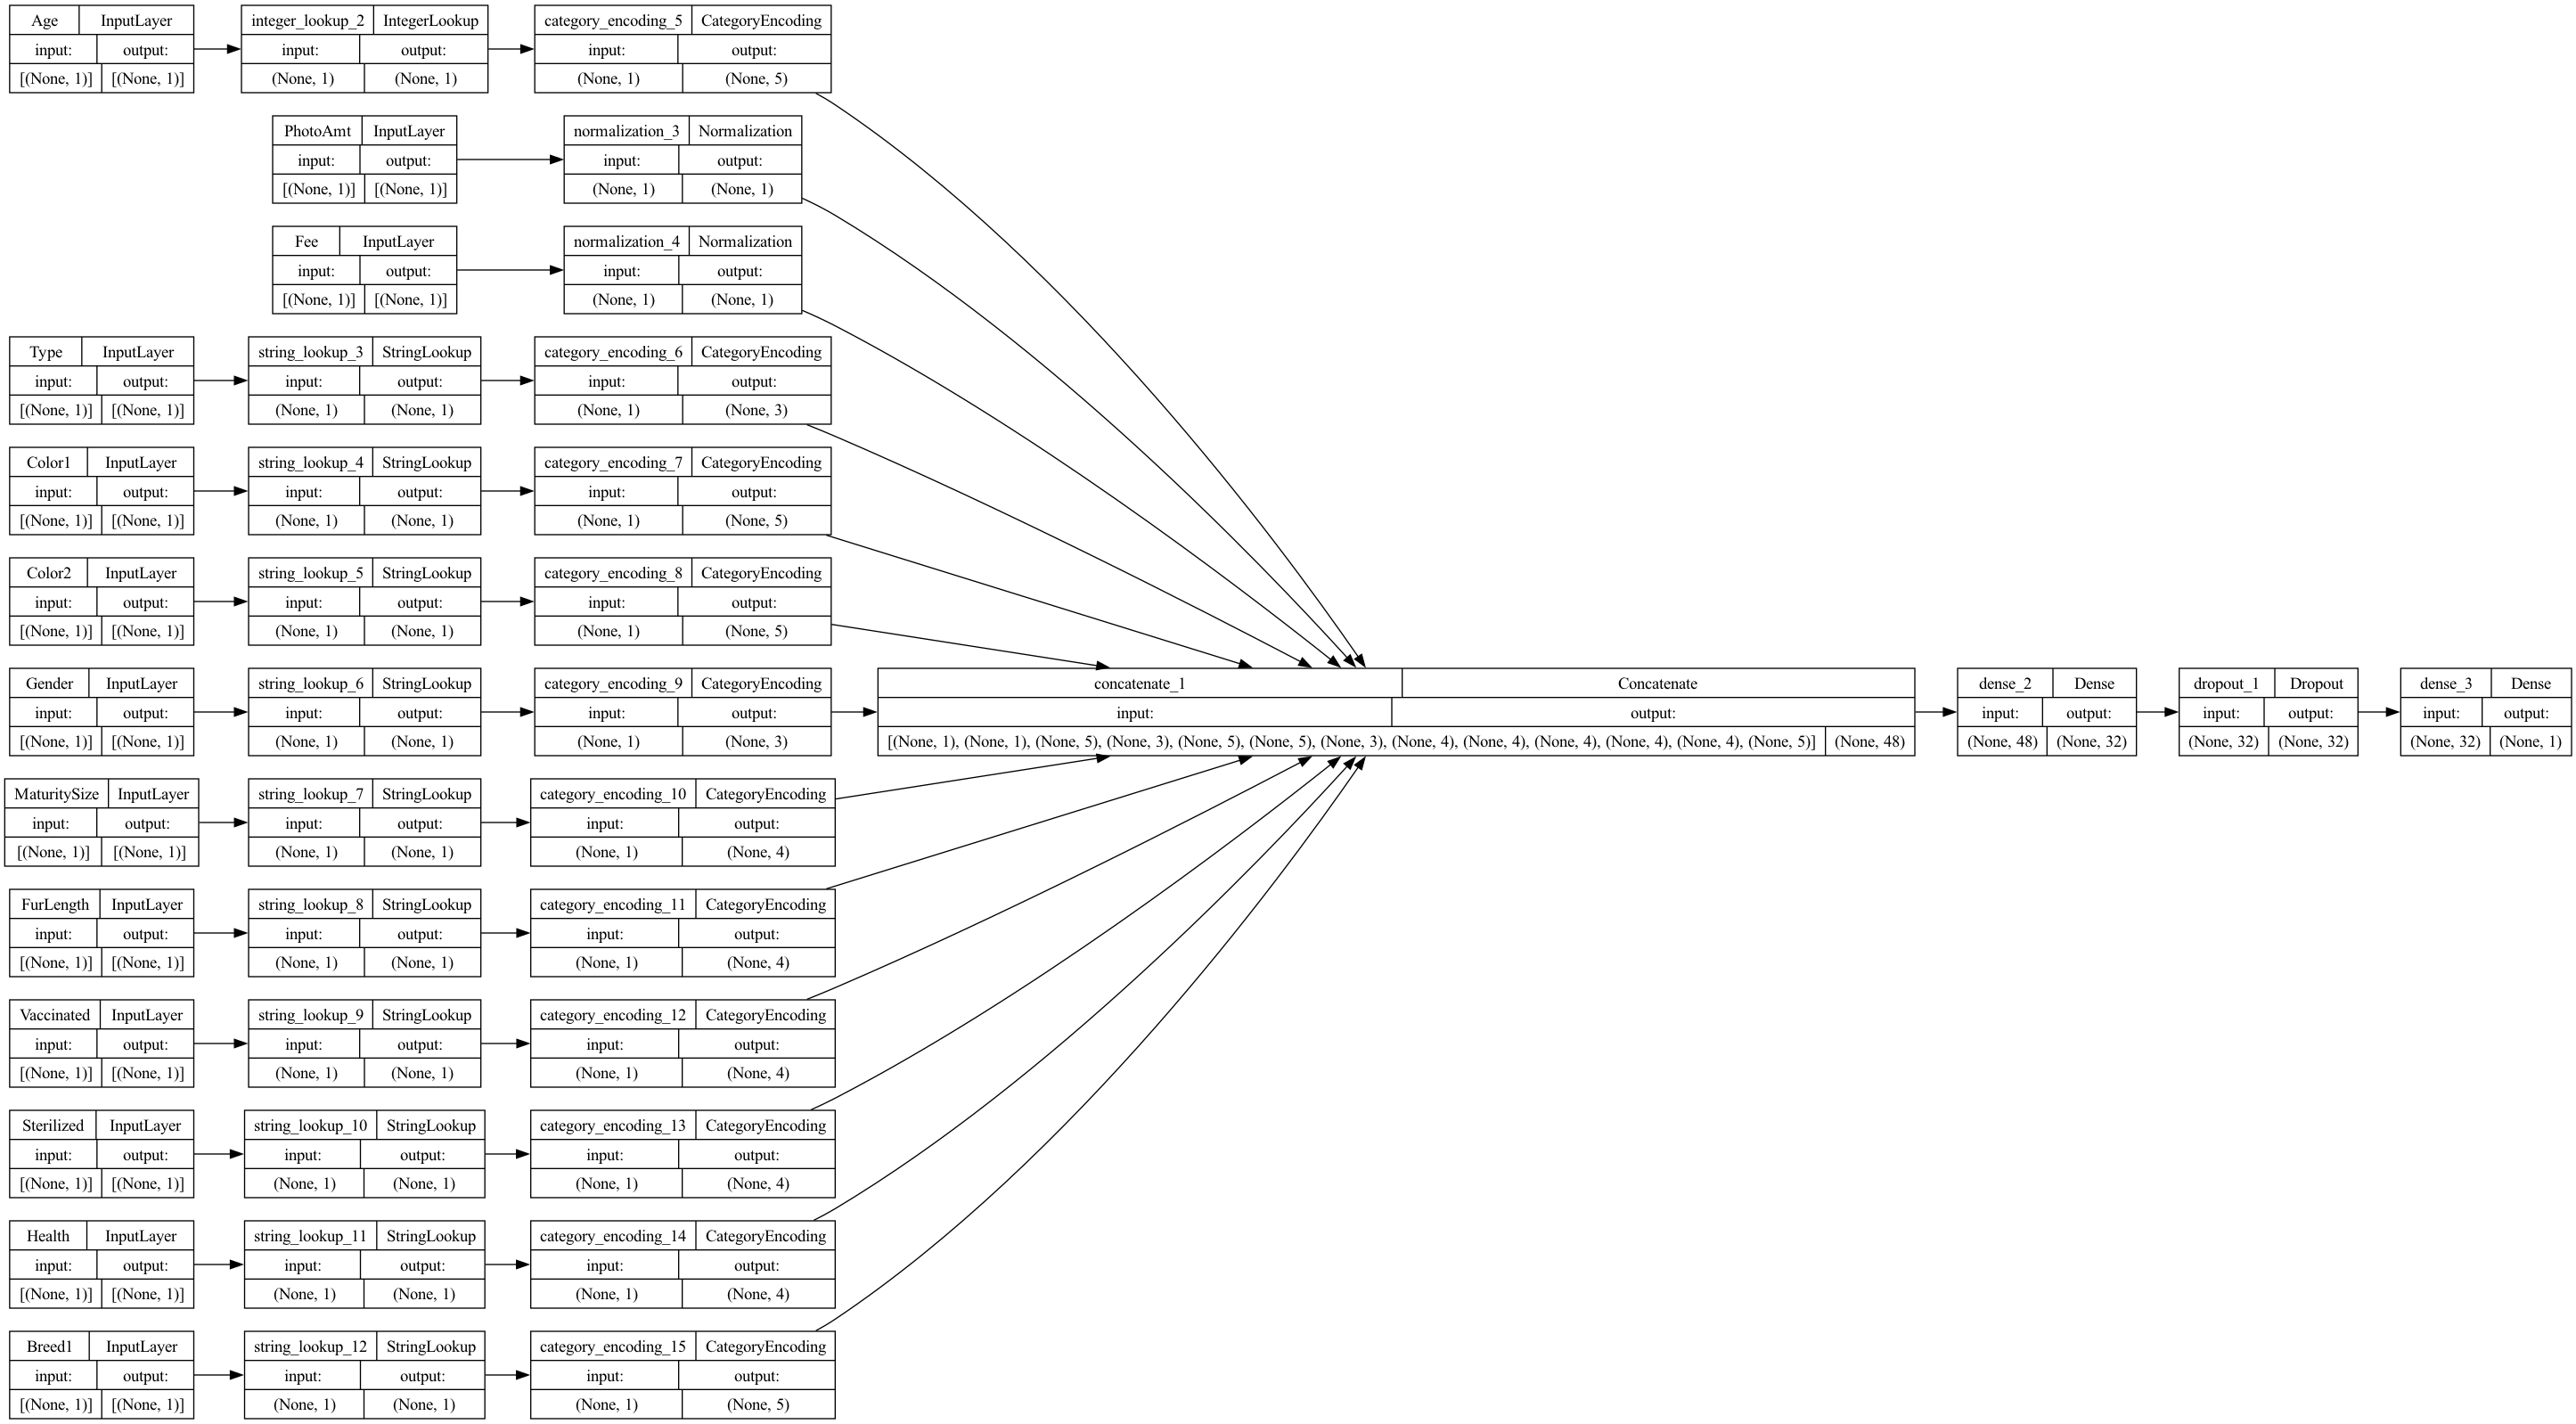

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [38]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 1s 9ms/step - loss: 0.6019 - accuracy: 0.6313 - val_loss: 0.5613 - val_accuracy: 0.7348
Epoch 2/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.6722 - val_loss: 0.5484 - val_accuracy: 0.7366
Epoch 3/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5545 - accuracy: 0.6867 - val_loss: 0.5405 - val_accuracy: 0.7400
Epoch 4/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.6931 - val_loss: 0.5360 - val_accuracy: 0.7357
Epoch 5/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5434 - accuracy: 0.7063 - val_loss: 0.5318 - val_accuracy: 0.7357
Epoch 6/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5328 - accuracy: 0.7134 - val_loss: 0.5293 - val_accuracy: 0.7348
Epoch 7/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.7164 - val_loss: 0.5268 - val_accuracy: 0.7348
Epoch 8/10
37/37 [=============

In [39]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 2ms/step - loss: 0.5117 - accuracy: 0.7374
Accuracy 0.737434983253479


### Perform Inference

In [40]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')


INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


In [41]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 240ms/step
This particular pet had a 81.6 percent probability of getting adopted.
